In [2]:
import numpy as np
from tqdm import tqdm
from math import sqrt,exp
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from qutip import *
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
# plt.rcParams["figure.figsize"]= 10, 7
plt.rcParams['figure.dpi'] = 100
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

global eta
eta = 0.2      # width of broadening function

# Comparison with 1D chain $(N > 2)$

In [3]:
def hopping(t, N):
    H_hop = 0
    for i in range(N):
        for spin in ['u', 'd']:
            if spin == 'u':
                op = [create(2), identity(2)]
            else:
                op = [identity(2), destroy(2)]
            pre = [identity(2)]*2*i
            site_i = op
            if i == N-1:
                pre  = op + pre[2:]
                site_j = []
                post = []
            else:
                site_j = op
                post = [identity(2)]*2*(N - i - 2)
            H_hop += tensor(pre+site_i+site_j+post)
    H_hop *= -t
    return H_hop + H_hop.dag()


def onsite(U, N):
    H_ons = 0
    for i in range(N):
        pre = [identity(2)]*2*i
        site_i = [create(2)*destroy(2) - 0.5, create(2)*destroy(2) - 0.5]
        post = [identity(2)]*2*(N - i - 1)
        H_ons += tensor(pre+site_i+post)
    return U*H_ons

In [4]:
def rho_at_w(args):
    (En, Xn), w = args
    Z = 1
    E0 = E[0]
    X0 = X[0]
    c0_up = tensor([identity(2)]*2*(N-1) + [destroy(2), identity(2)])
    C1 = X0.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*X0
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1=w + E0 - En
    x2=w + En - E0
    return (C1_sq * exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

    
t = 0.2
U = 0.1
td = 2*t
delta = sqrt(U**2 + 16*td**2)
ham = 0
N = 2
ham += hopping(t, N)
ham += onsite(U, N)
E, X = ham.eigenstates()
plt.scatter([delta/2 + td, delta/2 - td, -delta/2 - td, -delta/2 + td], [0,0,0,0])
combs = zip(E[1:], X[1:])
rho = []
w_range = np.arange(-1.5, 1.5, 0.02)
for w in tqdm(w_range):
    rho_w = 0
    rho_w = sum(map(rho_at_w, product(zip(E[1:], X[1:]), [w])))
    rho.append(rho_w)
    
plt.plot(w_range, rho)

[-0.80156098 -0.4        -0.4        -0.4        -0.4        -0.05
 -0.05       -0.05        0.05        0.05        0.05        0.4
  0.4         0.4         0.4         0.80156098]
100%|██████████| 150/150 [00:02<00:00, 52.22it/s]


In [ ]:
def gauss(x):
    return exp(-(x/eta)**2)/(eta*sqrt(np.pi))


delta = sqrt(U**2 + 16*t**2)
w_range = np.arange(-2, 2, 0.01)
rho = []
print (1 - 4*t/delta)
plt.axvline(0.5*delta - t, 0, 1)
plt.axvline(-0.5*delta - t, 0, 1)
plt.axvline(- delta/2 + t, 0, 1)
plt.axvline(delta/2 + t, 0, 1)
for w in w_range:
    rho.append((3/(2*N)) * (gauss(w - 0.5*delta + t) + gauss(w + 0.5*delta + t) + (1 + 4*t/delta)*gauss(w + delta/2 - t) + (1 - 4*t/delta)*gauss(w - delta/2 - t)))
plt.plot(w_range, rho)

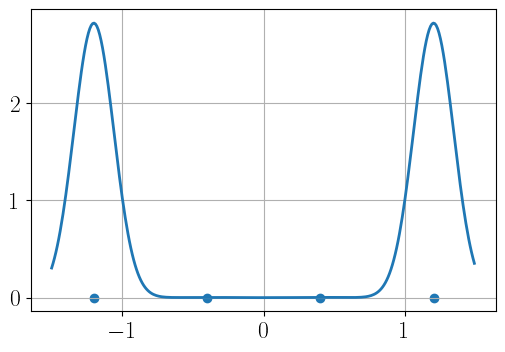

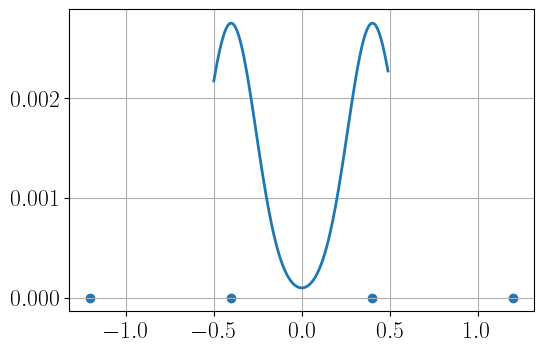

In [219]:
def gauss(x):
    return exp(-(x/eta)**2)/(eta*sqrt(np.pi))

td = t * 2
delta = sqrt(U**2 + 16*td**2)
w_range = np.arange(-1.5, 1.5, 0.01)
rho = []
plt.scatter([delta/2 + td, delta/2 - td, -delta/2 - td, -delta/2 + td], [0,0,0,0])
for w in w_range:
    rho.append((1/2 + 2*td/delta)*(gauss(w - delta/2 - td) + gauss(w + delta/2 + td)) +  (1/2 - 2*td/delta)*(gauss(w - delta/2 + td) + gauss(w + delta/2 - td)))
plt.plot(w_range, rho)
plt.show()
plt.scatter([delta/2 + td, delta/2 - td, -delta/2 - td, -delta/2 + td], [0,0,0,0])
w_range = np.arange(-0.5, 0.5, 0.01)
rho = []
for w in w_range:
    rho.append((1/2 + 2*td/delta)*(gauss(w - delta/2 - td) + gauss(w + delta/2 + td)) +  (1/2 - 2*td/delta)*(gauss(w - delta/2 + td) + gauss(w + delta/2 - td)))
plt.plot(w_range, rho)
plt.show()